# Task 4 - Soft Actor Critic
1. Collect Training Data
2. Compute Expected Returns
3. Actor-Critic Loss Function
4. Updating Parameters
5. Run Training in a Loop
6. Test

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import collections
import statistics
from tensorflow.keras import layers
from trd_env import trading_env
import tqdm
from pandas import DataFrame

In [2]:
df = pd.read_csv("btc_6H_(2016-2018).csv")
df.head()
env = trading_env(df)
env.reset()
env.render()
eps = np.finfo(np.float32).eps.item()

Current Porfolio Value:10000.00069660314; Available Capital: 10000; Current Stocks Held: 1e-06
No. Stocks Bought:1e-08; No. Stocks Sold:1e-07; Average Cost:0 
Return:6.966031396586914e-06%; 0.0006966031396586914
Termination date: 2016-10-31 00:00:00


In [3]:
class SAC(tf.keras.Model):
    
    def __init__(self, n_actions, n_hl): #number of actions, number of hidden layers employed
        super().__init__()
        
        self.ac = layers.Dense(n_hl, activation = "relu")
        self.actor = layers.Dense(n_actions) # Number of outputs
        self.critic = layers.Dense(1) #Number of outputs
        
    def call(self,ins):
        x = self.ac(ins)
        return self.actor(x), self.critic(x)

In [4]:
n_actions = 3
n_hl = 50

model = SAC(n_actions,n_hl)

## 1. Data Collection
* During forward pass, use environment state as inputs to generate action probabilities
* Critic Value based on the current policy parametized by model weight
* Next action sampled using action probabilites generated by the model - applied to the environment generating the next state and reward

In [5]:
def walk_env(action):
    state,reward,done = env.step(action)
    return(np.array(state,np.float32), # Might be an issue since our inputs is an array of 6
          np.array(reward,np.float32),
          np.array(done,np.float32))

def tf_env_walk(action):
    return tf.numpy_function(walk_env,[action],[tf.float32,tf.float32,tf.float32])

def collect(initial_state,model,max_steps):
    action_probabilities = tf.TensorArray(dtype = tf.float32, size=0, dynamic_size=True) # All action_probabilites
    c_values = tf.TensorArray(dtype = tf.float32, size=0, dynamic_size=True) # All critic_value
    rewards = tf.TensorArray(dtype = tf.float32, size=0, dynamic_size=True)
    
    init_state_shape = initial_state.shape
    state = initial_state
    for t in tf.range(max_steps):
        state = tf.expand_dims(state,0)
        action_proba, c_value = model(state)
        
        # Sample next action from the probability
        action = tf.random.categorical(action_proba,1)[0,0] # Draws sample from categorical distribution (chooses action)
        soft_action_proba = tf.nn.softmax(action_proba) # Calculates softmax probabilities for each action (calculates the probability of said chosen action)
        # Store log probability of chosen action
        action_probabilities = action_probabilities.write(t,soft_action_proba[0,action])
        
        # Store critic value
        c_values = c_values.write(t,tf.squeeze(c_value))
        
        # Apply action to environment
        state,reward,done = tf_env_walk(action)
        state.set_shape(init_state_shape[0])
        
        # Store reward
        rewards = rewards.write(t, reward)
        
        if tf.cast(done,tf.bool):
            break
        
    action_probabilities = action_probabilities.stack()
    c_values = c_values.stack()
    rewards = rewards.stack()
        
    return action_probabilities, c_values, rewards
        

## 2. Calculate expcted return
* Convert reward from each episode into a sequence of expected returns
* Sum of rewards taken from t to T and each reward is multiplied by the factor gamma
* To stabalise training, returns are standardized using mean and std

In [6]:
def exp_return(rewards,gamma,standardize=True):
    eps = 0.000001
    n = tf.shape(rewards)[0]
    returns = tf.TensorArray(size = n, dtype=tf.float32)
    
    # Latest Reward -> First Reward
    rewards = tf.cast(rewards[::-1],dtype =tf.float32)
    discounted_sum = tf.constant(0.0)
    discounted_sum_shape = discounted_sum.shape
    for i in tf.range(n):
        reward = rewards[i]
        discounted_sum = reward * gamma * discounted_sum #Bellman Equation
        discounted_sum.set_shape(discounted_sum_shape)
        returns = returns.write(i,discounted_sum)
    returns = returns.stack()[::-1]
    
    if standardize:
        returns = ((returns-tf.math.reduce_mean(returns))/(tf.math.reduce_std(returns)+eps))
        
    return returns
    

## 3. Defining Loss Function
* Actor Loss = Bellman Equation*[G-V]
* Advantage indicates how much better an action is given a particular state over random actions selected by a policy
* Critic Loss: Can be treated as a regression problem using Hubers Loss Function(Less sensetive to outliers relative to squared error loss)

In [7]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(action_probabilities, values,returns):
    advantage = returns-values
    action_lg_prob = tf.math.log(action_probabilities)
    actor_loss = -tf.math.reduce_sum(action_lg_prob * advantage)
    
    critic_loss = huber_loss(values,returns)
    return actor_loss + critic_loss

## 4. Training and Updating
* Runned every episode
* Use Adam Optimizer
* tf.GradienTape to enable autodiff
* Compute sum of undiscounted rewards to meet success criterion
* Use tf.function for the training step to improve training speed


In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)

@tf.function
def training(init_state,model,optimizer,gamma,max_step_per_episode)-> tf.Tensor:
    
    with tf.GradientTape() as tape:
        # Run model for one episode to collect data
        action_probabilities,values,rewards = collect(init_state,model,max_step_per_episode) # Works
        #Calculate expected Returns
        returns = exp_return(rewards,gamma) # works
        # Convert training data to fit TF shapes
        action_probabilities,values,returns = [tf.expand_dims(x,1) for x in [action_probabilities,values,returns]] # Works
        #Calculate loss values for the network
        loss = compute_loss(action_probabilities, values,returns)#works
        
    # Compute Loss gradient
    grads = tape.gradient(loss,model.trainable_variables)
    
    # Apply gradient to model parameters
    optimizer.apply_gradients(zip(grads,model.trainable_variables))
    
    episode_reward = tf.math.reduce_mean(rewards)
    
    return episode_reward    

## 5. Training Execution

In [27]:
%%time

min_episodes_criterion = 0
max_episodes = 1800
max_steps_per_episode = 1000

# Consecutive trials
reward_threshold = 100000
running_reward = 0

# Discount factor for future rewards
gamma = 0.93

# Keep last episodes reward
episodes_reward: collections.deque = collections.deque()
stock_tracker1 = []
reward_gm = []
reward_gm1 = []

with tqdm.trange(max_episodes) as t:
      for i in t:
        initial_state = tf.constant(env.reset(), dtype=tf.float32)
        episode_reward = int(training(initial_state, model, optimizer, gamma, max_steps_per_episode))

        episodes_reward.append(episode_reward)
        running_reward = statistics.mean(episodes_reward)
        return_perc, return_value, no_stocks_bought, no_stocks_sold, current_stocks_held  =  env.reward_output()
        stock_tracker1.append(current_stocks_held)
        reward_gm.append((gamma,return_value))
        reward_gm1.append((return_value))

        t.set_description(f'Episode {i}')
        t.set_postfix(
            episode_reward=episode_reward, running_reward=running_reward)

        # Show average episode reward every 10 episodes
        if i % 10 == 0:
              pass # print(f'Episode {i}: average reward: {avg_reward}')

        if running_reward > reward_threshold and i >= min_episodes_criterion:  
            break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

print(episode_reward)
print(env.render())

Episode 1799: 100%|████████████████████████████| 1800/1800 [10:44<00:00,  2.79it/s, episode_reward=0, running_reward=0]


Solved at episode 1799: average reward: 0.00!
0
Current Porfolio Value:20201.062793337507; Available Capital: 10478.23737014708; Current Stocks Held: 3.8787184839576936
No. Stocks Bought:125.662592303; No. Stocks Sold:121.78387490904231; Average Cost:2486.8992283618663 
Return:102.01062793337508%; 10201.062793337507
Termination date: 2017-07-08 00:00:00
None
Wall time: 10min 44s


In [19]:
# Find optimal Gamma to give highest mean return ran on 1000 episodes per Gamma
r_g = DataFrame(reward_gm, columns=['Gamma','Return'])
r_g1 = r_g.groupby('Gamma').mean() 
display(r_g1)

,Return
Gamma,
0.91,18677.047355
0.92,21466.562832
0.93,23646.926170
0.94,21615.915831
0.95,18014.507318
0.96,22480.233193
0.97,23380.503905
0.98,22633.960993
0.99,20960.287215


1800

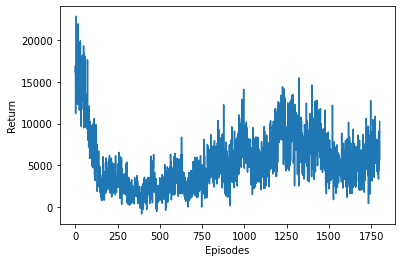

In [28]:
import matplotlib.pyplot as plt
x_axis = np.arange(0,1800)
plt.plot(x_axis, reward_gm1)
plt.xlabel('Episodes')
plt.ylabel('Return')
len(stock_tracker1)

1800

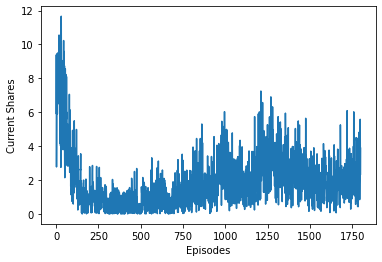

In [29]:

x_axis = np.arange(0,1800)
plt.plot(x_axis, stock_tracker1)
plt.xlabel('Episodes')
plt.ylabel('Current Shares')
len(stock_tracker1)

# 6. Test

In [30]:
test_df = pd.read_csv("btc_6H_(2020-2021).csv")
test_env = trading_env(df)
test_env.reset()
test_env.render()

Current Porfolio Value:10000.000696386187; Available Capital: 10000; Current Stocks Held: 1e-06
No. Stocks Bought:1e-08; No. Stocks Sold:1e-07; Average Cost:0 
Return:6.963861869735411e-06%; 0.000696386186973541
Termination date: 2016-10-31 00:00:00


In [24]:
state = tf.constant(test_env.reset(), dtype=tf.float32)
reward_tracker = []
stock_tracker11 = []
for i in range(0, len(test_df)-1):
    state = tf.expand_dims(state,0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))
    print(action)

    state, reward, done = test_env.step(action)
    state = tf.constant(state, dtype=tf.float32)
    return_perc, return_value, no_stocks_bought, no_stocks_sold, current_stocks_held =  env.reward_output()
    stock_tracker11.append(current_stocks_held)
    reward_tracker.append((return_value))

    # Render screen every 10 steps
    if i % 10 == 0:
        print(f"Current Step:{i}")
        test_env.render()
        print("********************************")
    if done:
          break
test_env.render()

2
Current Step:0
Current Porfolio Value:10000.000695038327; Available Capital: 10000.0; Current Stocks Held: 1e-06
No. Stocks Bought:1e-08; No. Stocks Sold:1e-07; Average Cost:0.0 
Return:6.9503832673945005e-06%; 0.00069503832673945
Termination date: 2016-10-31 06:00:00
********************************
2
2
2
2
2
2
2
2
2
2
Current Step:10
Current Porfolio Value:10000.000730655169; Available Capital: 10000.0; Current Stocks Held: 1e-06
No. Stocks Bought:1e-08; No. Stocks Sold:1e-07; Average Cost:0.0 
Return:7.306551688088803e-06%; 0.0007306551688088803
Termination date: 2016-11-02 18:00:00
********************************
2
2
2
2
2
2
2
2
2
2
Current Step:20
Current Porfolio Value:10016.595924453763; Available Capital: 3317.903839482383; Current Stocks Held: 9.55200394922816
No. Stocks Bought:9.552002959228162; No. Stocks Sold:1e-07; Average Cost:699.5491413147456 
Return:0.16595924453762564%; 16.595924453762564
Termination date: 2016-11-05 06:00:00
********************************
2
2
2


2
2
2
2
2
2
2
2
2
2
Current Step:370
Current Porfolio Value:13646.721236466412; Available Capital: 0.00041344245116959645; Current Stocks Held: 14.233061277227383
No. Stocks Bought:14.233060287227385; No. Stocks Sold:1e-07; Average Cost:702.5895126691646 
Return:36.46721236466412%; 3646.721236466412
Termination date: 2017-01-31 18:00:00
********************************
2
2
2
2
2
2
2
2
2
2
Current Step:380
Current Porfolio Value:14491.324144732664; Available Capital: 0.00032373912138673484; Current Stocks Held: 14.233061365480262
No. Stocks Bought:14.233060375480264; No. Stocks Sold:1e-07; Average Cost:702.5895146151819 
Return:44.913241447326634%; 4491.324144732664
Termination date: 2017-02-03 06:00:00
********************************
2
2
2
2
2
2
2
2
2
2
Current Step:390
Current Porfolio Value:14376.293734714121; Available Capital: 0.00032373912138673484; Current Stocks Held: 14.233061365480262
No. Stocks Bought:14.233060375480264; No. Stocks Sold:1e-07; Average Cost:702.5895146151819 

2
2
2
2
2
2
Current Step:740
Current Porfolio Value:21722.143181057614; Available Capital: 7.74834634767388e-13; Current Stocks Held: 14.233061687364533
No. Stocks Bought:14.233060697364534; No. Stocks Sold:1e-07; Average Cost:702.5895214715148 
Return:117.22143181057614%; 11722.143181057614
Termination date: 2017-05-04 06:00:00
********************************
2
2
2
2
2
2
2
2
2
2
Current Step:750
Current Porfolio Value:22170.475720274528; Available Capital: 2.8016843575858015e-13; Current Stocks Held: 14.233061687364533
No. Stocks Bought:14.233060697364534; No. Stocks Sold:1e-07; Average Cost:702.5895214715148 
Return:121.70475720274527%; 12170.475720274528
Termination date: 2017-05-06 18:00:00
********************************
2
2
2
2
2
2
2
2
2
2
Current Step:760
Current Porfolio Value:24632.274265705568; Available Capital: 1.4099817227401424e-13; Current Stocks Held: 14.233061687364533
No. Stocks Bought:14.233060697364534; No. Stocks Sold:1e-07; Average Cost:702.5895214715148 
Return

2
Current Porfolio Value:38492.04345598676; Available Capital: 7.042269561169539e-33; Current Stocks Held: 14.233061687364533
No. Stocks Bought:14.233060697364534; No. Stocks Sold:1e-07; Average Cost:702.5895214715148 
Return:284.9204345598676%; 28492.043455986757
Termination date: 2017-08-03 00:00:00


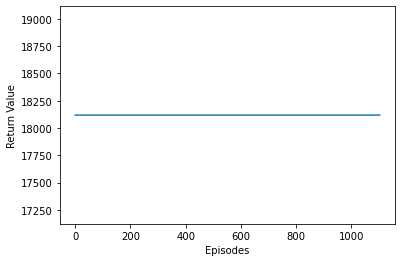

In [32]:
import matplotlib.pyplot as plt
x_axis = np.arange(0, 1104)
plt.xlabel('Episodes')
plt.ylabel('Return Value')
plt.plot(x_axis,reward_tracker)

Text(0, 0.5, 'Current Shares')

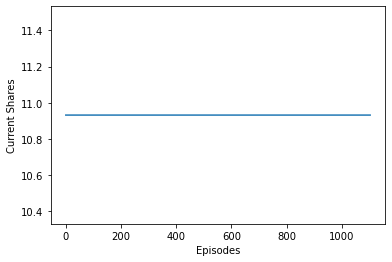

In [33]:
x_axis = np.arange(0,1104)
plt.plot(x_axis, stock_tracker11)
plt.xlabel('Episodes')
plt.ylabel('Current Shares')

In [ ]:
reward_tracker